          country  year  population
0     Afghanistan  1950     7480461
1         Albania  1950     1252582
2         Algeria  1950     9019866
3  American Samoa  1950       19032
4         Andorra  1950        6005
               year    population
count  17316.000000  1.731600e+04
mean    1986.500000  2.158477e+07
std       21.360626  9.608514e+07
min     1950.000000  5.100000e+02
25%     1968.000000  2.495690e+05
50%     1986.500000  3.273298e+06
75%     2005.000000  1.107062e+07
max     2023.000000  1.428628e+09
country       0
year          0
population    0
dtype: int64
Root Mean Squared Error (RMSE): 3034733.66
R2 Score: 0.9989


C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


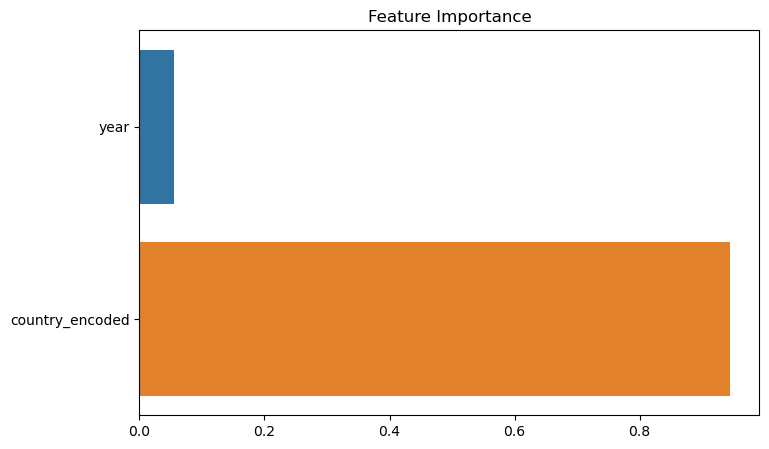

   year  country_encoded  predicted_population         country
0  2025                0          4.121996e+07     Afghanistan
1  2025                1          4.607583e+06         Albania
2  2025                2          4.385492e+07         Algeria
3  2025                3          1.849260e+06  American Samoa
4  2025                4          1.849260e+06         Andorra


In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 2. Load and Preprocess Data
population_df = pd.read_csv('world_population_by_year_1950_2023.csv')

# Reshape wide to long
population_long_df = population_df.melt(id_vars=["country"], 
                                         var_name="year", 
                                         value_name="population")

population_long_df['year'] = population_long_df['year'].astype(int)
population_long_df['population'] = pd.to_numeric(population_long_df['population'], errors='coerce')

# Drop any missing values (if any)
population_long_df.dropna(inplace=True)

# 3. Basic EDA
print(population_long_df.head())
print(population_long_df.describe())
print(population_long_df.isnull().sum())

# 4. Prepare Features and Target
# Features: year, country (encoded)
# Target: population

# Encoding country names (label encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
population_long_df['country_encoded'] = le.fit_transform(population_long_df['country'])

# Define X and y
X = population_long_df[['year', 'country_encoded']]
y = population_long_df['population']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Build and Train XGBoost Model
model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 7. Predict and Evaluate
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# 8. Feature Importance Visualization
importances = model.feature_importances_
feat_names = ['year', 'country_encoded']

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feat_names)
plt.title('Feature Importance')
plt.show()

# 9. Predict Future (Optional Bonus)
# Predict population for 2025, 2030, 2040 etc.

future_years = [2025, 2030, 2040, 2050]
future_preds = []

for year in future_years:
    for country_code in population_long_df['country_encoded'].unique():
        pred = model.predict(np.array([[year, country_code]]))
        future_preds.append({
            'year': year,
            'country_encoded': country_code,
            'predicted_population': pred[0]
        })

future_df = pd.DataFrame(future_preds)
# Decode country names back
future_df['country'] = le.inverse_transform(future_df['country_encoded'])

# See future population predictions
print(future_df.head())



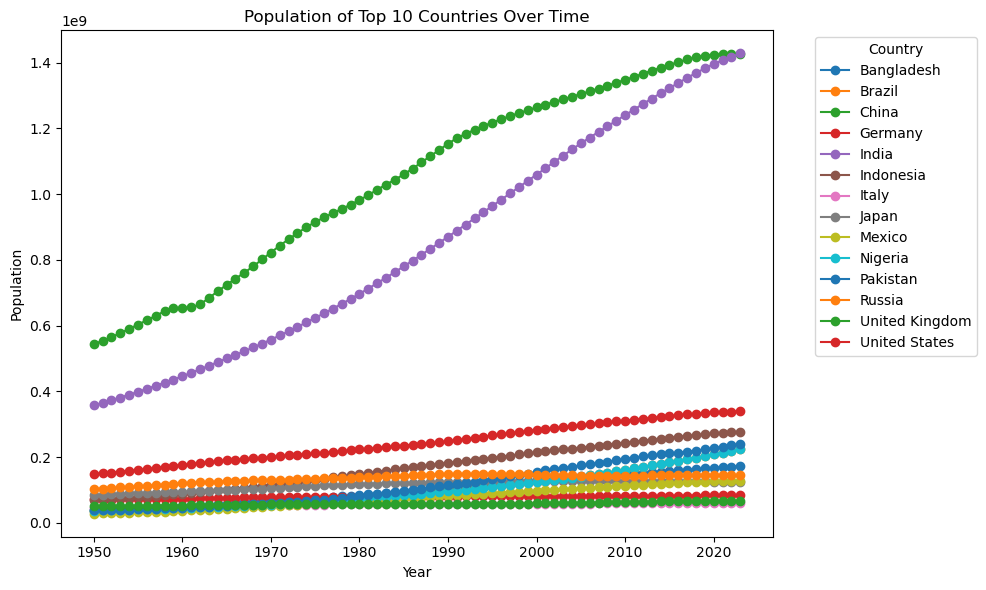

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('world_population_by_year_1950_2023.csv')


df_long = df.melt(id_vars=['country'], var_name='year', value_name='population')
df_long['year'] = df_long['year'].astype(int)

# Select every 10 years from 1960 to 2020
years = list(range(1960, 2021, 10))

# Determine top 10 countries by population for each selected year
top_countries = set()
for y in years:
    top10 = df_long[df_long['year'] == y].nlargest(10, 'population')['country']
    top_countries.update(top10)

# Filter DataFrame for the top countries
df_top = df_long[df_long['country'].isin(top_countries)]

# Pivot the data so that each country is a column
df_pivot = df_top.pivot(index='year', columns='country', values='population')

# Plot population trends for top countries over time
plt.figure(figsize=(10, 6))
for country in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[country], marker='o', label=country)

plt.title('Population of Top 10 Countries Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
